# Stream fit

### The stream is modelled with a segment of the orbit. The potential is kept fixed. The optimization is among the initial conditions of the stream progenitor.


In [1]:
from astropy import units as u
from astropy.coordinates import SkyCoord
import astropy.coordinates as coord
from scipy.integrate import solve_ivp
from astropy.io import ascii
from scipy import optimize

## The orbit model
The orbit should be integrated backwards and forwards during a given time span.

In [2]:
# Mass and density profile (RAR)

exec(open("./model_def.py").read())     

# Rar model evaluation
ener_f = 56.0  # keV
param = np.array([ener_f, 3.77656e+01,6.63407e+01,1.1977e-05])
r_mw,mass_mw = model(param)
rho_mw = np.diff(mass_mw)/np.diff(r_mw)/(4.0*np.pi*r_mw[:-1]**2)  # M_sun/pc^3

# Interpolation avoiding NANs
k = np.argwhere(np.isnan(mass_mw))[0][0]
r_sh = r_mw[0:k]
mass_sh = mass_mw[0:k]
r_max_mw=r_sh[-1]

mass_spline = InterpolatedUnivariateSpline(r_sh,mass_sh,k=4)  # Allows easy computation of derivatives
def rho_spline(r) :
    deriv= mass_spline.derivative(1)
    return deriv(r)/(4.0*np.pi*r*r)


37.7656 66.3407 1.1977e-05


/home/mmestre/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in sqrt
/home/mmestre/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in sqrt


In [3]:
# Gravitational acceleration

exec(open("./accelerations.py").read()) 
exec(open("./accelerations_combine.py").read()) 


def accel_mw(x,y,z):
    return accel_logarithmic(x,y,z)


#------------------
# Gradient generated by MW's halo
def symp_grad_mw(t, w):
    x=w[0]
    y=w[1]
    z=w[2]
    px=w[3]
    py=w[4]
    pz=w[5]
    r=np.sqrt(x*x+y*y+z*z)
    return [px,py,pz, -accel_mw(x,y,z)[0], -accel_mw(x,y,z)[1], -accel_mw(x,y,z)[2]]

print( symp_grad_mw(1.0,np.array([1,1,1,1,1,1])) )
print(2.3e7*409)

r_200= 209.41344788869304
a_nfw= 17.451120657391087
[1, 1, 1, -14963.358778625954, -14963.358778625954, -18473.282442748092]
9407000000.0


In [4]:
# from Gala Package (to acknowledge)
""" Astropy coordinate class for the Sagittarius coordinate system """

# Third-party
import numpy as np

import astropy.units as u
import astropy.coordinates as coord
from astropy.coordinates import frame_transform_graph
from astropy.coordinates.matrix_utilities import matrix_transpose

__all__ = ["GD1Koposov10", "GD1"]



class GD1Koposov10(coord.BaseCoordinateFrame):
    """
    A Heliocentric spherical coordinate system defined by the orbit
    of the GD1 stream, as described in
    Koposov et al. 2010 (see: `<http://arxiv.org/abs/0907.1085>`_).

    For more information about this class, see the Astropy documentation
    on coordinate frames in :mod:`~astropy.coordinates`.

    Parameters
    ----------
    representation : :class:`~astropy.coordinates.BaseRepresentation` or None
        A representation object or None to have no data (or use the other keywords)

    phi1 : angle_like, optional, must be keyword
        The longitude-like angle corresponding to GD-1's orbit.
    phi2 : angle_like, optional, must be keyword
        The latitude-like angle corresponding to GD-1's orbit.
    distance : :class:`~astropy.units.Quantity`, optional, must be keyword
        The Distance for this object along the line-of-sight.

    pm_phi1_cosphi2 : :class:`~astropy.units.Quantity`, optional, must be keyword
        The proper motion in the longitude-like direction corresponding to
        the GD-1 stream's orbit.
    pm_phi2 : :class:`~astropy.units.Quantity`, optional, must be keyword
        The proper motion in the latitude-like direction perpendicular to the
        GD-1 stream's orbit.
    radial_velocity : :class:`~astropy.units.Quantity`, optional, must be keyword
        The Distance for this object along the line-of-sight.

    """
    default_representation = coord.SphericalRepresentation
    default_differential = coord.SphericalCosLatDifferential

    frame_specific_representation_info = {
        coord.SphericalRepresentation: [
            coord.RepresentationMapping('lon', 'phi1'),
            coord.RepresentationMapping('lat', 'phi2'),
            coord.RepresentationMapping('distance', 'distance')],
    }

    _default_wrap_angle = 180*u.deg

    def __init__(self, *args, **kwargs):
        wrap = kwargs.pop('wrap_longitude', True)
        super().__init__(*args, **kwargs)
        if wrap and isinstance(self._data, (coord.UnitSphericalRepresentation,
                                            coord.SphericalRepresentation)):
            self._data.lon.wrap_angle = self._default_wrap_angle

    # TODO: remove this. This is a hack required as of astropy v3.1 in order
    # to have the longitude components wrap at the desired angle

    def represent_as(self, base, s='base', in_frame_units=False):
        r = super().represent_as(base, s=s, in_frame_units=in_frame_units)
        r.lon.wrap_angle = self._default_wrap_angle
        return r





# Rotation matrix as defined in the Appendix of Koposov et al. (2010)
R = np.array([[-0.4776303088, -0.1738432154, 0.8611897727],
              [0.510844589, -0.8524449229, 0.111245042],
              [0.7147776536, 0.4930681392, 0.4959603976]])


@frame_transform_graph.transform(coord.StaticMatrixTransform, coord.ICRS,
                                 GD1Koposov10)
def icrs_to_gd1():
    """ Compute the transformation from Galactic spherical to
        heliocentric GD1 coordinates.
    """
    return R


@frame_transform_graph.transform(coord.StaticMatrixTransform, GD1Koposov10,
                                 coord.ICRS)
def gd1_to_icrs():
    """ Compute the transformation from heliocentric GD1 coordinates to
        spherical Galactic.
    """
    return matrix_transpose(icrs_to_gd1())


# TODO: remove this in next version
class GD1(GD1Koposov10):
    def __init__(self, *args, **kwargs):
        import warnings
        warnings.warn("This frame is deprecated. Use GD1Koposov10 instead.",
                      DeprecationWarning)
        super().__init__(*args, **kwargs)


trans = frame_transform_graph.get_transform(GD1Koposov10,
                                            coord.ICRS).transforms[0]
frame_transform_graph.add_transform(GD1, coord.ICRS, trans)
trans = frame_transform_graph.get_transform(coord.ICRS,
                                            GD1Koposov10).transforms[0]
frame_transform_graph.add_transform(coord.ICRS, GD1, trans)

w_0 =  [  -1.71638445   14.01126978    9.22796594 -203.11524263 -136.89835301
   34.28826607]


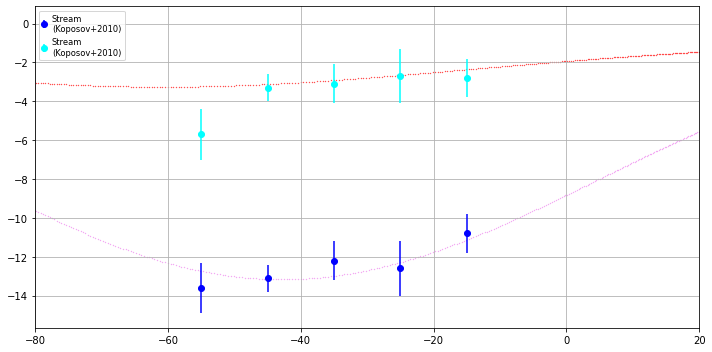

w_0 =  [  -1.71638445   14.01126978    9.22796594 -203.11524263 -136.89835301
   34.28826607]
chi^2 = 105.32506441069722
105.32506441069722


In [19]:
# Computation of the orbit model for Koposov+10 logarithmic potential and data.

# This cell contains additional computations outside the main objective of this notebook.
# The orbit_model here defined works with cartesian coordinates both in the input and output.

exec(open("./stream_Koposov_data.py").read()) 

# Orbit model definition
#-------------------------------------
def orbit_model(w_0):
    print('w_0 = ',w_0)
    
    # ODE integration
    unit_t = 0.977792221680356   # Gyr
    time_span_s2 = 0.2/unit_t #
    t_0=0.0/unit_t    
    n_steps = 1000
    t_back = np.linspace(t_0,-time_span_s2, n_steps+1)
    t_forw = np.linspace(t_0,time_span_s2, n_steps+1)       
    sol_back = solve_ivp(symp_grad_mw, [t_0,-time_span_s2], w_0, t_eval=t_back,method='DOP853',rtol=5.0e-14,atol=0.5e-14)
    sol_forw = solve_ivp(symp_grad_mw, [t_0,time_span_s2], w_0, t_eval=t_forw,method='DOP853',rtol=5.0e-14,atol=0.5e-14)
    
    t = np.concatenate([sol_back.t,sol_forw.t])
    y = np.concatenate([sol_back.y, sol_forw.y],axis=1)
    #print(np.shape(y))
    y = np.delete(y,0,axis=1) #Remove duplicated column
    #print(np.shape(y))
    
    #Transformation to GD-1 frame of coordinates (\phi_1, \phi_2)
    galcen_distance = 8.5*u.kpc
    v_sun = coord.CartesianDifferential([11.1, 220.0+12.24, 7.25]*u.km/u.s)
    z_sun=0.0*u.kpc
    galac_coord=coord.Galactocentric(x=y[0]*u.kpc,y=y[1]*u.kpc,z=y[2]*u.kpc,
                                     v_x=y[3]*u.km/u.s,v_y=y[4]*u.km/u.s,v_z=y[5]*u.km/u.s,
                           galcen_distance=galcen_distance,galcen_v_sun=v_sun,z_sun=z_sun) 
    gd1_coord = galac_coord.transform_to(GD1Koposov10)
    phi_1 = gd1_coord.phi1
    phi_2 = gd1_coord.phi2
    d_hel = gd1_coord.distance
    v_hel = gd1_coord.radial_velocity
    mu_phi_1 = gd1_coord.pm_phi1_cosphi2/np.cos(phi_2)
    mu_phi_2 = gd1_coord.pm_phi2
    
    return phi_1, phi_2, d_hel, v_hel, mu_phi_1, mu_phi_2  #the time "t" is not needed

# Test call:
#------------------
#w_0=np.array([-3.41, 13.0, 9.58, -200.4, -162.6, 13.9])
w_0=np.array([-1.716384450138328077e+00, 1.401126977875537705e+01, 9.227965941367614278e+00,-2.031152426286328421e+02, -1.368983530061972260e+02, 3.428826606652827280e+01])
phi_1,phi_2,d_hel,v_hel,mu_1,mu_2 = orbit_model(w_0) 
    
# Plots in the sky using the GD-1 frame
#------------------------------------------------------
fig=plt.figure(figsize=(10,5))

# sky position
#plt.scatter(phi_1.wrap_at(180*u.deg),phi_2,s=0.1,marker='o', color='red')
#plt.scatter(phi_1,phi_2,s=0.1,marker='o', color='violet')
#plt.errorbar(kop_sky['phi1'], kop_sky['phi2'], yerr=kop_sky['err'], fmt='o', color='cyan', label='Stream\n(Koposov+2010)')
#plt.ylim(-4,2)

# heliocentric radial velocity 
#plt.scatter(phi_1.wrap_at(180*u.deg),v_hel,s=0.1,marker='o', color='red')
#plt.errorbar(kop_rv['phi1'], kop_rv['vr'], yerr=kop_rv['err'], fmt='o', color='cyan', label='Stream\n(Koposov+2010)')
#plt.ylim(-400,200)

# heliocentric distance
#plt.scatter(phi_1,d_hel,s=0.1,marker='o', color='violet')
#plt.errorbar(kop_dist['phi1'], kop_dist['dist'], yerr=kop_dist['err'], fmt='o', color='cyan', label='Stream\n(Koposov+2010)')
#plt.ylim(5,15)

# proper motion along phi_1 and phi_2
plt.scatter(phi_1,mu_1,s=0.1,marker='o', color='violet')
plt.scatter(phi_1,mu_2,s=0.1,marker='o', color='red')
plt.errorbar(kop_pm['phi1'], kop_pm['mu_phi1'], yerr=kop_pm['err'], fmt='o', color='blue', label='Stream\n(Koposov+2010)')
plt.errorbar(kop_pm['phi1'], kop_pm['mu_phi2'], yerr=kop_pm['err'], fmt='o', color='cyan', label='Stream\n(Koposov+2010)')

plt.xlim(-80,20)
plt.grid()
plt.legend(fontsize='small', handlelength=0.3)

plt.tight_layout()
plt.show()
fig.savefig("plots/pm_fit_my_w0.png")

# Optimization
#-------------------------------------

def chi2(w_0):
    phi_1,phi_2,d_hel,v_hel,mu_1,mu_2 = orbit_model(w_0) 
    phi_2_spl = interp1d(phi_1,phi_2,kind='cubic')
    d_hel_spl = interp1d(phi_1,d_hel,kind='cubic')
    v_hel_spl = interp1d(phi_1,v_hel,kind='cubic')
    mu_1_spl  = interp1d(phi_1,mu_1,kind='cubic')
    mu_2_spl  = interp1d(phi_1,mu_2,kind='cubic')

    sum=np.zeros(5)

    y_mod = phi_2_spl(kop_sky['phi1'])
    y_dat = kop_sky['phi2']
    sigma2 = kop_sky['err']**2
    sum[0] = np.sum( (y_dat-y_mod)**2 / sigma2 )

    y_mod = v_hel_spl(kop_rv['phi1'])
    y_dat = kop_rv['vr']
    sigma2 = kop_rv['err']**2
    sum[1] = np.sum( (y_dat-y_mod)**2 / sigma2 )
    
    y_mod = d_hel_spl(kop_dist['phi1'])
    y_dat = kop_dist['dist']
    sigma2 = kop_dist['err']**2
    sum[2] = np.sum( (y_dat-y_mod)**2 / sigma2 )
    
    y_mod = mu_1_spl(kop_pm['phi1'])
    y_dat = kop_pm['mu_phi1']
    sigma2 = kop_pm['err']**2
    sum[3] = np.sum( (y_dat-y_mod)**2 / sigma2 )
    
    y_mod = mu_2_spl(kop_pm['phi1'])
    y_dat = kop_pm['mu_phi2']
    sigma2 = kop_pm['err']**2
    sum[4] = np.sum( (y_dat-y_mod)**2 / sigma2 )
    
    print('chi^2 =',np.sum(sum))
    return np.sum(sum)

print(chi2(w_0))


dx = 5.0
dv = 30.0
w_0=np.array([-3.41, 13.0, 9.58, -200.4, -162.6, 13.9]) 
bounds=((w_0[0]-dx,w_0[0]+dx), (w_0[1]-dx,w_0[1]+dx), (w_0[2]-dx,w_0[2]+dx),
        (w_0[3]-dv,w_0[3]+dv), (w_0[4]-dv,w_0[4]+dv), (w_0[5]-dv,w_0[5]+dv))

#opt=optimize.differential_evolution(chi2, bounds,strategy='best1bin',maxiter=20,popsize=20,tol=5.0e-8,atol=0.5e-8,disp=True,polish=True,workers=-1)

#param_fitted = opt.x

#np.savetxt('param_fitted.txt', param_fitted, delimiter=',')  

param=  157.6 43.717 8.25 -4.71963667724046 -11.0 -90.0
[-29d40m52.7522s -29d24m43.9669s -29d08m37.9836s ... 119d21m05.2751s
 119d15m02.3114s 119d08m59.4448s]
[ 8.26529519  8.2806815   8.29615789 ... 24.54955643 24.55037698
 24.5511391 ] kpc


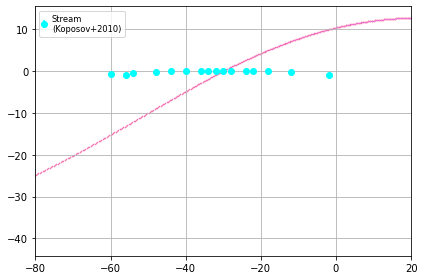

In [21]:
# Computation of the orbit model for Ibata+20 potential.
# The initial condition is from them also.


def orbit_model(alpha,delta,distance,mu_alpha,mu_delta,v_los):
    print('param= ',alpha,delta,distance,mu_alpha,mu_delta,v_los)
    
    # Transformation to galactocentric coordinates
    sky_coord = coord.ICRS(ra=alpha*u.degree, dec=delta*u.degree,
                distance=distance*u.kpc,
                pm_ra_cosdec=mu_alpha*np.cos(delta*u.degree)*u.mas/u.yr,
                pm_dec=mu_delta*u.mas/u.yr,
                radial_velocity=v_los*u.km/u.s)
    galcen_distance = 8.129*u.kpc
    v_sun = coord.CartesianDifferential([11.1, 229.0+12.24, 7.25]*u.km/u.s)
    z_sun=0.0*u.kpc
    frame = coord.Galactocentric(galcen_distance=galcen_distance,
                                galcen_v_sun=v_sun,
                                z_sun=z_sun)
    galac_coord= sky_coord.transform_to(frame)
    
    w_0 = np.zeros(6)
    w_0[:3]=[galac_coord.x/u.kpc,galac_coord.y/u.kpc,galac_coord.z/u.kpc]
    w_0[3:]=[galac_coord.v_x/(u.km/u.s),galac_coord.v_y/(u.km/u.s),galac_coord.v_z/(u.km/u.s)]
    
    
    # ODE integration
    unit_t = 0.977792221680356   # Gyr
    time_span_s2 = 0.2/unit_t #
    t_0=0.0/unit_t    
    n_steps = 1000
    t_back = np.linspace(t_0,-time_span_s2, n_steps+1)
    t_forw = np.linspace(t_0,time_span_s2, n_steps+1)       
    sol_back = solve_ivp(symp_grad_mw, [t_0,-time_span_s2], w_0, t_eval=t_back,method='DOP853',rtol=5.0e-14,atol=0.5e-14)
    sol_forw = solve_ivp(symp_grad_mw, [t_0,time_span_s2], w_0, t_eval=t_forw,method='DOP853',rtol=5.0e-14,atol=0.5e-14)
    
    t = np.concatenate([sol_back.t,sol_forw.t])
    y = np.concatenate([sol_back.y, sol_forw.y],axis=1)
    y = np.delete(y,0,axis=1) #Remove duplicated column
    
    #Transformation to GD-1 frame of coordinates (\phi_1, \phi_2)
    galac_coord=coord.Galactocentric(x=y[0]*u.kpc,y=y[1]*u.kpc,z=y[2]*u.kpc,
                                     v_x=y[3]*u.km/u.s,v_y=y[4]*u.km/u.s,v_z=y[5]*u.km/u.s,
                           galcen_distance=galcen_distance,galcen_v_sun=v_sun,z_sun=z_sun) 
    gd1_coord = galac_coord.transform_to(GD1Koposov10)
    phi_1 = gd1_coord.phi1
    phi_2 = gd1_coord.phi2
    d_hel = gd1_coord.distance
    v_hel = gd1_coord.radial_velocity
    #mu_phi_1 = gd1_coord.pm_phi1_cosphi2/np.cos(phi_2)  #not used by Ibata
    #mu_phi_2 = gd1_coord.pm_phi2
    # Transformation to ICRS coordinates      
    icrs_coord=galac_coord.transform_to(coord.ICRS)
    mu_ra = icrs_coord.pm_ra_cosdec
    mu_dec= icrs_coord.pm_dec
    return t, phi_1, phi_2, d_hel, v_hel, mu_ra, mu_dec

# test call:
valor_pm_ra=-6.53  #adimensional
valor_dec=43.717
valor_cosdec= np.cos(valor_dec*u.deg)
valor_pm_ra_cosdec=valor_pm_ra*valor_cosdec
t,phi_1,phi_2,d_hel,v_hel,mu_ra,mu_dec = orbit_model(157.6,valor_dec, 8.25, valor_pm_ra_cosdec ,-11.0 , -90.0) 
    
print(phi_1)
print(d_hel)

# Plots in the sky using the GD-1 frame

# sky position
plt.scatter(phi_1.wrap_at(180*u.deg),phi_2,s=0.1,marker='o', color='red')
plt.scatter(phi_1,phi_2,s=0.1,marker='o', color='violet')
plt.errorbar(kop_sky['phi1'], kop_sky['phi2'], yerr=kop_sky['err'], fmt='o', color='cyan', label='Stream\n(Koposov+2010)')
# heliocentric radial velocity 
#plt.scatter(phi_1.wrap_at(180*u.deg),v_hel,s=0.1,marker='o', color='red')
#plt.errorbar(kop_rv['phi1'], kop_rv['vr'], yerr=kop_rv['err'], fmt='o', color='cyan', label='Stream\n(Koposov+2010)')
#plt.ylim(-400,200)

# heliocentric distance
#plt.scatter(phi_1,d_hel,s=0.1,marker='o', color='violet')
#plt.errorbar(kop_dist['phi1'], kop_dist['dist'], yerr=kop_dist['err'], fmt='o', color='cyan', label='Stream\n(Koposov+2010)')
#plt.ylim(5,15)

# proper motion along phi_1 and phi_2
#plt.scatter(phi_1,mu_1,s=0.1,marker='o', color='violet')
#plt.scatter(phi_1,mu_2,s=0.1,marker='o', color='red')
#plt.errorbar(kop_pm['phi1'], kop_pm['mu_phi1'], yerr=kop_pm['err'], fmt='o', color='blue', label='Stream\n(Koposov+2010)')
#plt.errorbar(kop_pm['phi1'], kop_pm['mu_phi2'], yerr=kop_pm['err'], fmt='o', color='cyan', label='Stream\n(Koposov+2010)')

plt.xlim(-80,20)
plt.grid()
plt.legend(fontsize='small', handlelength=0.3)


plt.tight_layout()
plt.show()

In [20]:
a=np.concatenate([[[1,2,3],[4,5,6]],[[7,8,9],[10,11,12]]],axis=1)
print(a)
print(np.shape(a))

[[ 1  2  3  7  8  9]
 [ 4  5  6 10 11 12]]
(2, 6)
